In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm

import sys
sys.path.append("../")
from bargains_linear import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


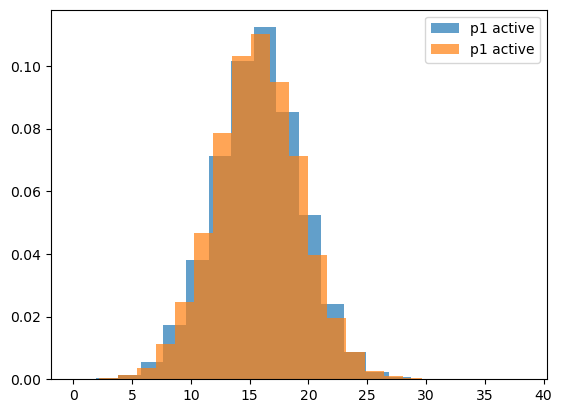

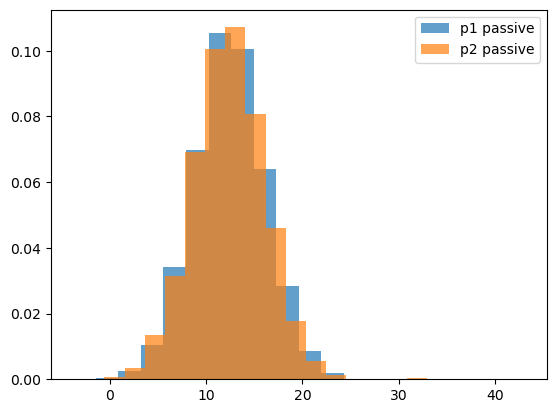

In [2]:
seq_result = pd.read_csv('fake_data/seq_data_1.csv',index_col=0)
active_result = pd.read_csv('fake_data/active_data_1.csv',index_col=0)
passive_result = pd.read_csv('fake_data/passive_data_1.csv',index_col=0)

plt.hist(active_result['p1'],bins=20,density=True,alpha=.7,label='p1 active')
plt.hist(active_result['p2'],bins=20,density=True,alpha=.7,label='p1 active')
plt.legend()
plt.savefig('figures/hist_active.png',dpi=300)
plt.show()

plt.hist(passive_result['p1'],bins=20,density=True,alpha=.7,label='p1 passive')
plt.hist(passive_result['p2'],bins=20,density=True,alpha=.7,label='p2 passive')
plt.legend()
plt.savefig('figures/hist_passive.png',dpi=300)
plt.show()

In [3]:
seq_result = pd.read_csv('fake_data/seq_data_4.csv',index_col=0)
active_result = pd.read_csv('fake_data/active_data_4.csv',index_col=0)
passive_result = pd.read_csv('fake_data/passive_data_4.csv',index_col=0)

In [4]:
#calculate moment conditions for the linear model...
def solve_parameters_obj(data,params, active=False,seq=False):
    wtp,cost,beta1,beta2 = params
    
    data_moments = list(data.mean())
    phi1,phi2 = None,None
    if seq:
        phi1,phi2 = seq_bargain(25, cost, wtp, [0,0],betas=[beta1,beta2])
    elif active:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [0,0],active=True,betas=[beta1,beta2])
    else:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [0,0],active=False,betas=[beta1,beta2])
    
    phi1,phi2,p1,p2,s1,s2 = solve_eq(phi1,phi2,cost,wtp,[0,0])
    computed_moments = [phi1,phi2,p1,p2,s1,s2]
    
    obj = 0
    for i in range(6):
        obj = obj + (1 + 5*(i>4) ) *(data_moments[i] - computed_moments[i])**2
    
    return obj
    

print( solve_parameters_obj(seq_result,[25,5,.5,.5], seq=True) )
print( solve_parameters_obj(seq_result,[25,5,.5,.5], active=True) )


print( solve_parameters_obj(active_result,[25,5,.5,.5], active=True) )
print( solve_parameters_obj(active_result,[25,5,.5,.5], seq=True) )


print( solve_parameters_obj(passive_result,[25,5,.5,.5], active=False) )
print( solve_parameters_obj(passive_result,[25,5,.5,.5], active=True) )

5.667458692365449
96.39717329837882
0.9439204599185822
80.1768263641381
0.006786853791273893
155.3255130276101


In [5]:
def solve_parameters(data,active=False,seq=False): 
    obj = lambda params: solve_parameters_obj(data,params,active=active,seq=seq)
    params = minimize(obj, [25,5,.5,.5], options={'fatol':1e-6,'xatol':1e-6,'maxiter':20},method='Nelder-Mead').x # 
    return params

subsample0 = seq_result.sample(frac=0.1)
subsample1 = active_result.sample(frac=0.1)
subsample2 = active_result.sample(frac=0.1)
params_seq0 = (solve_parameters(subsample0,active=False,seq=True))
params_seq1 = (solve_parameters(subsample1,active=False,seq=True))
params_seq2 = (solve_parameters(subsample2,active=False,seq=True))
print(params_seq0)
print(params_seq1)
print(params_seq2)

[24.37534411  4.85091737  0.38942647  0.68142784]
[18.18930116  5.12171799  0.44146798  0.78430401]
[20.0235213   5.03836665  0.53175038  0.59366085]


In [6]:
#calculate moment conditions for the linear model...
def test_statistic(data, params, active=False,seq=False):
    wtp,cost,beta1,beta2 = params
    
    data_moments = list(data.mean())
    phi1,phi2 = None,None
    if seq:
        phi1,phi2 = seq_bargain(25, cost, wtp, [0,0],betas=[beta1,beta2])
    elif active:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [0,0],active=True,betas=[beta1,beta2])
    else:
        phi1,phi2 = simult_bargain(25,25, cost, wtp, [0,0],active=False,betas=[beta1,beta2])
    
    phi1,phi2,p1,p2,s1,s2 = solve_eq(phi1,phi2,cost,wtp,[0,0])
    computed_moments = [phi1,phi2,p1,p2,s1,s2]
    
    test_stat = data.copy()[['phi1','phi2','p1','p2','s1']]
    for i in range(5):
        test_stat[test_stat.columns[i]] =  test_stat[test_stat.columns[i]] - computed_moments[i]
    
    mean = test_stat.mean()
   
    cov = test_stat.cov()

    return np.abs(mean.dot(np.linalg.inv(cov)).dot(mean)) #need this for the case when beta1=beta2


t0 = test_statistic(subsample0, params_seq0,active=False,seq=True) 
t1 = test_statistic(subsample1, params_seq1,active=False,seq=True)
t2 = test_statistic(subsample2, params_seq2,active=False,seq=True)

In [7]:
for j in range(6):
    seq_result = pd.read_csv('fake_data/seq_data_%s.csv'%j,index_col=0)
    active_result = pd.read_csv('fake_data/active_data_%s.csv'%j,index_col=0)
    passive_result = pd.read_csv('fake_data/passive_data_%s.csv'%j,index_col=0)
    
    
    seq_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2']) 
    active_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2']) 
    passive_params_df = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2']) 
    
    for i in range(100):
        #resample from seq
        subsample = seq_result.sample(frac=0.1)
        params =  solve_parameters(subsample,active=False,seq=True)
        obj = test_statistic(subsample,params, active=False,seq=True)
        row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2'],
                           data=[[obj]+list(params)])
        seq_params_df = pd.concat( [seq_params_df, row] )


        #solve active
        subsample = active_result.sample(frac=0.1)
        params =  solve_parameters(subsample,active=False,seq=True)
        obj = test_statistic(subsample,params,active=False,seq=True)
        row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2'],
                           data=[[obj]+list(params)])
        active_params_df = pd.concat( [active_params_df, row] )

        #solve passive
        subsample = passive_result.sample(frac=0.1)
        params =  solve_parameters(subsample,active=False,seq=True)
        obj = test_statistic(subsample,params,active=False,seq=True)
        row = pd.DataFrame(columns=['obj','wtp','cost','beta1','beta2'],
                           data=[[obj]+list(params)])
        passive_params_df = pd.concat( [passive_params_df, row] )


    seq_params_df.to_csv('fake_params/seq_params_mc_%s.csv'%j)
    active_params_df.to_csv('fake_params/active_param_mc_%s.csv'%j)
    passive_params_df.to_csv('fake_params/passive_params_mc_%s.csv'%j)

In [12]:
def print_test(data):
    model1 = sm.OLS(data['phi2'],sm.add_constant(data[['phi1','c1']]))
    param, se = model1.fit().params.rename('param'),model1.fit().bse.rename('se')
    return pd.merge(param,se,left_index=True,right_index=True)

def run_test(data):
    regression_result = print_test(data)
    test_statistic = regression_result.loc['c1','param']/regression_result.loc['c1','se']
    test_result = (test_statistic > 1.96)
    return test_result

results = pd.DataFrame(columns=['dgp','test1','test2'])

for j in range(6):
    seq_result = pd.read_csv('fake_data/seq_data_%s.csv'%j,index_col=0)
    active_result = pd.read_csv('fake_data/active_data_%s.csv'%j,index_col=0)
    passive_result = pd.read_csv('fake_data/passive_data_%s.csv'%j,index_col=0)
    
    seq_params_df = pd.read_csv('fake_params/seq_params_mc_%s.csv'%j,index_col=0)
    active_params_df = pd.read_csv('fake_params/active_param_mc_%s.csv'%j,index_col=0)
    passive_params_df = pd.read_csv('fake_params/passive_params_mc_%s.csv'%j,index_col=0)


    test1p = 0
    test2p = 0
    test3p = 0
    nobs = 1000
    for i in range(nobs):
    
        subsample1 = seq_result.sample(frac=0.1)
        test1p = test1p + run_test(subsample1)
        
        subsample2 = active_result.sample(frac=0.1)
        test2p = test2p + run_test(subsample2)
        
        subsample3 = passive_result.sample(frac=0.1)
        test3p = test3p + run_test(subsample3)
        
    test1j=(seq_params_df['obj']>5).mean()
    test2j=(active_params_df['obj']>5).mean()
    test3j=(passive_params_df['obj']>5).mean()
    
    row = pd.DataFrame(columns=['dgp','test1','test2'],
        data=[['sequential',test1p/nobs,test1j],
             ['active',test2p/nobs,test2j],
             ['passive',test3p/nobs,test3j]])
    
    results = pd.concat( [results, row] )
    
print(results)
results.to_csv('mc_results_1207.csv')

          dgp  test1  test2
0  sequential  0.001   0.22
1      active  1.000   1.00
2     passive  1.000   1.00
0  sequential  0.054   0.08
1      active  1.000   1.00
2     passive  1.000   1.00
0  sequential  1.000   1.00
1      active  0.996   1.00
2     passive  1.000   1.00
0  sequential  0.003   0.18
1      active  1.000   1.00
2     passive  1.000   1.00
0  sequential  0.005   0.02
1      active  1.000   1.00
2     passive  1.000   1.00
0  sequential  0.000   0.96
1      active  1.000   1.00
2     passive  1.000   1.00


In [ ]:
plt.hist(seq_params_df['obj'])
plt.show()
plt.hist(active_params_df['obj'])
plt.show()
plt.hist(passive_params_df['obj'])
plt.show()
plt.hist(seq_params_df['obj']-active_params_df['obj'])
plt.show()
plt.hist(seq_params_df['obj']-passive_params_df['obj'])
plt.show()